# Imports

In [23]:
# Basics
import pandas as pd
import numpy as np

# utils
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve
from deepchecks.tabular import Dataset
from deepchecks.tabular.suites import full_suite
import shap
from collections import Counter
from tqdm import tqdm
import time
import pickle

# Models
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Read Data

In [2]:
train_data_path = "data/processed/sample_train.csv"
test_data_path = "data/processed/sample_test.csv"
vt_train_data_path = "data/virustotal/train_vt_data.csv"
vt_test_data_path = "data/virustotal/test_vt_data.csv"

In [3]:
raw_train = pd.read_csv(train_data_path)
raw_test = pd.read_csv(test_data_path)
vt_train_df = pd.read_csv(vt_train_data_path)
vt_test_df = pd.read_csv(vt_test_data_path)

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.


In [4]:
raw_train.columns

Index(['sha256', 'md5', 'appeared', 'label', 'avclass', 'size', 'vsize',
       'has_debug', 'exports', 'imports', 'has_relocations', 'has_resources',
       'has_signature', 'has_tls', 'symbols', 'numstrings', 'avlength',
       'printables', 'entropy', 'paths', 'urls', 'registry', 'MZ'],
      dtype='object')

# Feature Engineering

In [5]:
def feature_engineering(input_df, feature_cols_lst,mode='train'):
    df = input_df.copy()
    df['has_debug_relocations_resources_signature']=df['has_debug']*df['has_relocations']*df['has_resources']*df['has_signature']
    # set hash as index and extract feature cols
    df.set_index('sha256', inplace=True)
    df = df[feature_cols_lst + ['label']]
    if mode == 'train':
        # drop duplicates
        df.drop_duplicates(inplace=True)
    return df

In [6]:
feature_cols = ['size', 'vsize',
                'exports', 'imports',
                'has_tls', 'symbols',
                'avlength',
                'printables', 'entropy', 'paths', 'urls',
                'registry',
                'has_debug_relocations_resources_signature']

correlated_cols = ['numstrings', 'MZ'] # we came to the conclusion that we wont use these columns

In [7]:
df_train = feature_engineering(raw_train, feature_cols)
df_test = feature_engineering(raw_test, feature_cols, mode = 'test')

In [8]:
print(f"train original shape: {raw_train.shape}")
print(f"train shape after preprocess: {df_train.shape}")
print(f"test shape: {df_test.shape}")

train original shape: (160000, 23)
train shape after preprocess: (147776, 14)
test shape: (120000, 14)


# Dimensionality Reduction

In [9]:
X = df_train[feature_cols].values
y = df_train['label'].values

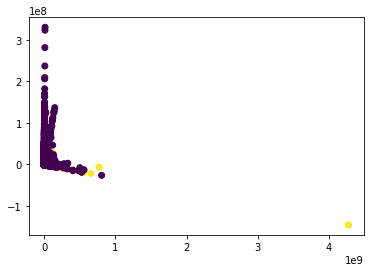

In [10]:
# perform PCA
pca = PCA()
pca.fit(X)
data_pca = pca.transform(X)
# plot the results
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=df_train['label'])
plt.show()

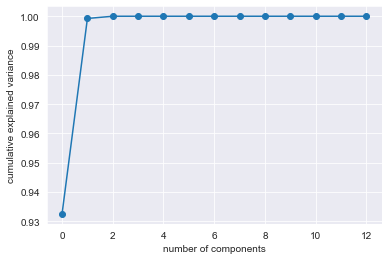

In [13]:
# plot pca cummulative explained variance
var_cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(var_cumsum)
plt.scatter(x=range(var_cumsum.shape[0]), y = var_cumsum)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

# Hyper Paramater Tuning

In [27]:
# our models
model_dic = {
    'baseline' : LogisticRegression,
    'xgboost' : xgb.XGBClassifier,
    'random_forest' : RandomForestClassifier,
    'adaboost' : AdaBoostClassifier
}

hp_dic = {
    'baseline' : {'C': [0.1,1,10]},
    'xgboost' : {
        'max_depth': [3,4,5],
        'learning_rate': [0.05,0.1,0.3],
        'n_estimators': [50, 100, 200, 300],
        'gamma': [0, 0.5, 1]
        },

    'random_forest' : {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [3, 4, 5],
        'min_samples_split': [2, 3, 20], 
        'min_samples_leaf': [1, 2, 10], 
    },
    'adaboost' : {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.01,0.05,0.1,0.3],
    }
}

In [28]:
def get_best_params(models_dic,hp_dic):
    """
    find the best paramaters given models and hyper paramters to search
    models_dic: dictionary of models
    hp_dic: dictionary of hyper parameters
    """
    best_params_dic = {}
    for model in models_dic.keys():
        print(f"starting grid search for {model}")
        start = time.time()
        clf = models_dic[model]()
        clf = RandomizedSearchCV(clf, hp_dic[model], cv=3, scoring='roc_auc', n_jobs=-1)
        clf.fit(X, y)
        best_params_dic[model] = clf.best_params_
        print(f"finished grid search for {model} in {round(time.time() - start,2)} seconds")
    return best_params_dic

In [29]:
try:
    with open('data/model_results/best_params_dic.pkl', 'rb') as f:
        best_params_dic = pickle.load(f)
except:
    best_params_dic = get_best_params(model_dic,hp_dic)
    with open('data/model_results/best_params_dic.pkl', 'wb') as f:
        pickle.dump(best_params_dic, f)

starting grid search for baseline


The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.


finished grid search for baseline in 4.17 seconds
starting grid search for xgboost
finished grid search for xgboost in 69.17 seconds
starting grid search for random_forest
finished grid search for random_forest in 52.7 seconds
starting grid search for adaboost
finished grid search for adaboost in 111.08 seconds


In [27]:
# train the model
X_train = df_train[feature_cols]
y_train = df_train['label']
# xgb_model = xgb.XGBClassifier()
# xgb_model.fit(X_train, y_train)

In [12]:
# define the dataset
dc_train = Dataset(df_train, label = 'label', cat_features= [])
dc_test = Dataset(df_test, label = 'label', cat_features= [])
# define checks object
suite = full_suite()

In [13]:
# suite.run(train_dataset = dc_train, test_dataset = dc_test, model = xgb_model)

invalid value encountered in longlong_scalars


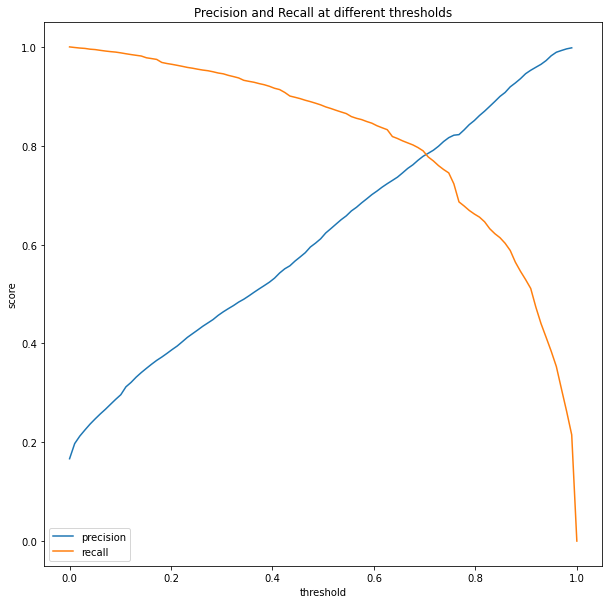

In [14]:
# get precision and recall at different thresholds
def get_precision_recall(y_true, y_pred, threshold):
    y_pred = (y_pred > threshold).astype(int)
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    tn = np.sum((y_pred == 0) & (y_true == 0))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return precision, recall

# get the predictions
y_pred = xgb_model.predict_proba(df_test[feature_cols])[:, 1]
# get the precision and recall at different thresholds
thresholds = np.linspace(0, 1, 100)
precisions = []
recalls = []
for threshold in thresholds:
    precision, recall = get_precision_recall(df_test['label'], y_pred, threshold)
    precisions.append(precision)
    recalls.append(recall)
# plot the results
plt.figure(figsize=(10, 10))
plt.plot(thresholds, precisions, label='precision')
plt.plot(thresholds, recalls, label='recall')
plt.legend()
plt.xlabel('threshold')
plt.ylabel('score')
plt.title('Precision and Recall at different thresholds')
plt.show()


In [15]:
# calc tpr at fpr = 0.1
y_pred = xgb_model.predict_proba(df_test[feature_cols])[:, 1]
fpr, tpr, thresholds = roc_curve(df_test['label'], y_pred)
# find the threshold that gives fpr = 0.001
wanted_fpr = 0.1
idx = np.argmin(np.abs(fpr - wanted_fpr))
wanted_tpr = tpr[idx]
print(f'TPR at FPR = {wanted_fpr}: {wanted_tpr}')

TPR at FPR = 0.1: 0.87435


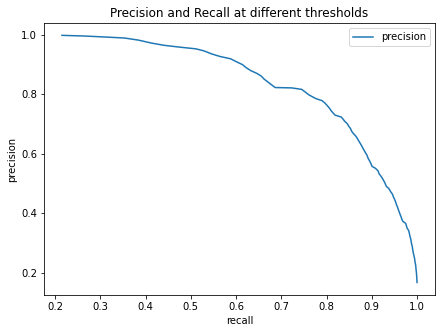

In [16]:
# plot the results
plt.figure(figsize=(7, 5))
plt.plot(recalls, precisions, label='precision')
plt.legend()
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision and Recall at different thresholds')
plt.show()


In [17]:
# s_data = shap.maskers.Independent(X_train)

In [18]:
# plot shap values
# explainer = shap.Explainer(xgb_model, X_train.iloc[:1000])
# shap_values = explainer(X_train.iloc[:1000])

In [19]:
# shap.plots.beeswarm(shap_values)

# Extract Results

In [20]:
# get predictions probabilities
y_test_pred = xgb_model.predict_proba(df_test[feature_cols])[:, 1]
y_train_pred = xgb_model.predict_proba(df_train[feature_cols])[:, 1]
# save to dataframes
df_test['pred'] = y_test_pred
df_train['pred'] = y_train_pred

In [31]:
# create results dataframe
train_results = df_train[['pred', 'label']]
test_results = df_test[['pred', 'label']]
# merge with vt_df
train_results = train_results.merge(vt_train_df, left_index=True, right_on='sha256',how='left')
test_results = test_results.merge(vt_test_df, left_index=True, right_on='sha256', how='left')

In [33]:
test_results.shape

(120000, 7)

In [35]:
train_results = train_results[['sha256', 'pred', 'label', 'num_undetected', 'num_malicious']]
test_results = test_results[['sha256', 'pred', 'label', 'num_undetected', 'num_malicious']]
train_results.to_csv('data/results/train_results.csv', index=False)
test_results.to_csv('data/results/test_results.csv', index=False)